# NFL Fantasy Football - Captsone Project

In [49]:
# Importing all the necessary modules

import pandas as pd
import numpy as np
import requests
import time

from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV,\
RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from operator import itemgetter
from math import sqrt
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
from matplotlib import pyplot as plt

# Overview

For this project, we compare the Root Mean Square Error ("RMSE")of the same dataset with varying degrees of features. The difference in features will be explained in the 'Data' section. The RMSE compared was between a dummy, linear regression, ridge, lasso, and random forest model.

This project was originally inspired by [Ben Dominguez](https://www.opensourcefootball.com/posts/2021-01-21-nfl-game-prediction-using-logistic-regression/) project which models NFL game outcomes. I was going to try using the same library 'nflfastpy', but it seems that it's been altered in the past two years and would not work the way it was outlined in his paper.

# Part 1 - Web Scraping the Data
- If you'd like to see how I scraped the data, please checkout 'Web_Scraping_Players_Data.ipynb' in the main folder!

# Part 2 - Cleaning the dataframe and Regressions
- This csv was made via webscraping, and if you'd like to see how it was done please reference the notebook labeled 'Webscraping'

In [50]:
# Loading in the csv
offense_nfl_df = pd.read_csv('offense_nfl_2022.csv')

In [51]:
# Checking the dataframe to make sure it was created properly
offense_nfl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8704 entries, 0 to 8703
Data columns (total 49 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8704 non-null   int64  
 1   Name        8704 non-null   object 
 2   Pos         8704 non-null   object 
 3   Date        8704 non-null   object 
 4   Team        8704 non-null   object 
 5   Opp1        8704 non-null   object 
 6   Lg          8704 non-null   object 
 7   Att         8704 non-null   int64  
 8   Cmp         8704 non-null   int64  
 9   Pct         8704 non-null   float64
 10  Pass_Yds    8704 non-null   int64  
 11  YPA         8704 non-null   float64
 12  Pass_TD     8704 non-null   int64  
 13  TD%T%       8704 non-null   float64
 14  Int         8704 non-null   int64  
 15  Int%I%      8704 non-null   float64
 16  Lg.1        8704 non-null   object 
 17  FD          8704 non-null   object 
 18  20+         8704 non-null   object 
 19  Sack        8704 non-null  

In [52]:
# Only want to keep columns that will be relevant to regressions
clean_nfl_df = offense_nfl_df[['Name','Pos','Date','Team','Opp1','Pass_Yds','Pass_TD','Int','Date.1','Team.1','Opp2','Rush_Yds','Rush_TD','Date.2','Team.2','Opp3','Rec','Rec_Yds','Rec_TD','Tar']]

In [53]:
clean_nfl_df.tail(5)

,Name,Pos,Date,Team,Opp1,Pass_Yds,Pass_TD,Int,Date.1,Team.1,Opp2,Rush_Yds,Rush_TD,Date.2,Team.2,Opp3,Rec,Rec_Yds,Rec_TD,Tar
8699,Tyler Mabry,TE,0,0,0,0,0,0,08/13/22,SEA,@ PIT,0,0,08/13/22,SEA,@ PIT,1,7,0,2
8700,Tyler Mabry,TE,0,0,0,0,0,0,08/18/22,SEA,vs CHI,0,0,08/18/22,SEA,vs CHI,0,0,0,1
8701,Tyler Mabry,TE,0,0,0,0,0,0,01/01/23,SEA,vs NYJ,0,0,01/01/23,SEA,vs NYJ,1,7,1,1
8702,Tyler Mabry,TE,0,0,0,0,0,0,01/08/23,SEA,vs LA,0,0,01/08/23,SEA,vs LA,0,0,0,0
8703,Tyler Mabry,TE,0,0,0,0,0,0,01/14/23,SEA,@ SF,0,0,01/14/23,SEA,@ SF,0,0,0,0


### Part 2.1 - Cleaning the dataframe
- As seen above some Date/Team/Opp are missing, so in order to have them all match I'm replacing wherever Opp1 is equal to 0.
- Doing this for Opp1, Team, and Date
- After there are no more 0's in these three columns I will drop the others

In [54]:
clean_nfl_df.loc[clean_nfl_df['Opp1'] == "0", "Opp1"] = clean_nfl_df['Opp3']
clean_nfl_df.loc[clean_nfl_df['Opp1'] == "0", "Opp1"] = clean_nfl_df['Opp2']

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [55]:
clean_nfl_df.loc[clean_nfl_df['Team'] == "0", "Team"] = clean_nfl_df['Team.2']
clean_nfl_df.loc[clean_nfl_df['Team'] == "0", "Team"] = clean_nfl_df['Team.1']

In [56]:
clean_nfl_df.loc[clean_nfl_df['Date'] == "0", "Date"] = clean_nfl_df['Date.2']
clean_nfl_df.loc[clean_nfl_df['Date'] == "0", "Date"] = clean_nfl_df['Date.1']

In [57]:
clean_nfl_df = clean_nfl_df[['Name','Pos','Date','Team','Opp1','Pass_Yds','Pass_TD','Int','Rush_Yds','Rush_TD','Rec','Rec_Yds','Rec_TD','Tar']]

### Cont. Part 2.1 - Turning Date to date.time

In [58]:
clean_nfl_df['Date'] = pd.to_datetime(clean_nfl_df['Date'])

In [59]:
# Confirming it was changed to datetime
clean_nfl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8704 entries, 0 to 8703
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Name      8704 non-null   object        
 1   Pos       8704 non-null   object        
 2   Date      8704 non-null   datetime64[ns]
 3   Team      8704 non-null   object        
 4   Opp1      8704 non-null   object        
 5   Pass_Yds  8704 non-null   int64         
 6   Pass_TD   8704 non-null   int64         
 7   Int       8704 non-null   int64         
 8   Rush_Yds  8704 non-null   int64         
 9   Rush_TD   8704 non-null   int64         
 10  Rec       8704 non-null   int64         
 11  Rec_Yds   8704 non-null   int64         
 12  Rec_TD    8704 non-null   int64         
 13  Tar       8704 non-null   int64         
dtypes: datetime64[ns](1), int64(9), object(4)
memory usage: 952.1+ KB


In [60]:
# Only regular season games
# September 8, 2022 – January 8, 2023
clean_nfl_df = clean_nfl_df.loc[(clean_nfl_df['Date'] > '2022-09-07') & (clean_nfl_df['Date'] < '2023-01-09')]

In [61]:
# Splitting the Opp1 column to be able to one hot encode out later.
clean_nfl_df[['acr','Opp']] = clean_nfl_df['Opp1'].str.split(' ', expand=True)
clean_nfl_df

,Name,Pos,Date,Team,Opp1,Pass_Yds,Pass_TD,Int,Rush_Yds,Rush_TD,Rec,Rec_Yds,Rec_TD,Tar,acr,Opp
1,Josh Allen,QB,2022-09-08,BUF,@ LA,297,3,2,56,1,0,0,0,0,@,LA
2,Josh Allen,QB,2022-09-19,BUF,vs TEN,317,4,0,10,0,0,0,0,0,vs,TEN
3,Josh Allen,QB,2022-09-25,BUF,@ MIA,400,2,0,47,0,0,0,0,0,@,MIA
4,Josh Allen,QB,2022-10-02,BUF,@ BAL,213,1,1,70,1,0,0,0,0,@,BAL
5,Josh Allen,QB,2022-10-09,BUF,vs PIT,424,4,1,42,0,0,0,0,0,vs,PIT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,Dareke Young,WR,2022-12-24,SEA,@ KC,0,0,0,0,0,0,0,0,0,@,KC
8696,Dareke Young,WR,2023-01-01,SEA,vs NYJ,0,0,0,0,0,0,0,0,0,vs,NYJ
8697,Dareke Young,WR,2023-01-08,SEA,vs LA,0,0,0,0,0,2,24,0,2,vs,LA
8701,Tyler Mabry,TE,2023-01-01,SEA,vs NYJ,0,0,0,0,0,1,7,1,1,vs,NYJ


In [62]:
# Don't need Opp1 or acr anymore since I just split it above
clean_nfl_df = clean_nfl_df[['Name','Pos','Date','Team','Pass_Yds','Pass_TD','Int','Rush_Yds','Rush_TD','Rec','Rec_Yds','Rec_TD','Tar','Opp']]
clean_nfl_df

,Name,Pos,Date,Team,Pass_Yds,Pass_TD,Int,Rush_Yds,Rush_TD,Rec,Rec_Yds,Rec_TD,Tar,Opp
1,Josh Allen,QB,2022-09-08,BUF,297,3,2,56,1,0,0,0,0,LA
2,Josh Allen,QB,2022-09-19,BUF,317,4,0,10,0,0,0,0,0,TEN
3,Josh Allen,QB,2022-09-25,BUF,400,2,0,47,0,0,0,0,0,MIA
4,Josh Allen,QB,2022-10-02,BUF,213,1,1,70,1,0,0,0,0,BAL
5,Josh Allen,QB,2022-10-09,BUF,424,4,1,42,0,0,0,0,0,PIT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,Dareke Young,WR,2022-12-24,SEA,0,0,0,0,0,0,0,0,0,KC
8696,Dareke Young,WR,2023-01-01,SEA,0,0,0,0,0,0,0,0,0,NYJ
8697,Dareke Young,WR,2023-01-08,SEA,0,0,0,0,0,2,24,0,2,LA
8701,Tyler Mabry,TE,2023-01-01,SEA,0,0,0,0,0,1,7,1,1,NYJ


In [63]:
#Saving this step for after train_test split
#ohe_clean_nfl_df = pd.get_dummies(clean_nfl_df, columns=['Pos','Team','Opp'])
#ohe_clean_nfl_df

In [64]:
# Creating two dataframes, one for the first half of the season (training data) and one for the second half of the
# season (will have the target data)
# ohe -> one hot encodable

ohe_first_half_nfl = clean_nfl_df.loc[clean_nfl_df['Date'] < '2022-11-08']
ohe_second_half_nfl = clean_nfl_df.loc[clean_nfl_df['Date'] > '2022-11-08']

In [65]:
# Inspecting how many data points are in each
ohe_first_half_nfl #3565
ohe_second_half_nfl #3604

,Name,Pos,Date,Team,Pass_Yds,Pass_TD,Int,Rush_Yds,Rush_TD,Rec,Rec_Yds,Rec_TD,Tar,Opp
9,Josh Allen,QB,2022-11-13,BUF,330,1,2,84,0,0,0,0,0,MIN
10,Josh Allen,QB,2022-11-20,BUF,197,1,0,7,0,0,0,0,0,CLE
11,Josh Allen,QB,2022-11-24,BUF,253,2,1,78,1,0,0,0,0,DET
12,Josh Allen,QB,2022-12-01,BUF,223,2,0,20,0,0,0,0,0,NE
13,Josh Allen,QB,2022-12-11,BUF,147,1,0,47,1,0,0,0,0,NYJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,Dareke Young,WR,2022-12-24,SEA,0,0,0,0,0,0,0,0,0,KC
8696,Dareke Young,WR,2023-01-01,SEA,0,0,0,0,0,0,0,0,0,NYJ
8697,Dareke Young,WR,2023-01-08,SEA,0,0,0,0,0,2,24,0,2,LA
8701,Tyler Mabry,TE,2023-01-01,SEA,0,0,0,0,0,1,7,1,1,NYJ


In [66]:
#Removing Dates in both df in order to groupby name and sum
ohe_first_half_nfl = ohe_first_half_nfl.drop(columns='Date')
ohe_second_half_nfl = ohe_second_half_nfl.drop(columns='Date')

In [67]:
# Problem right now is I don't have the same number of players for both dataframes.
# In order to solve this I'll need to trim, both dataframes to make sure only one set of
# players are in both.
ohe_first_half_nfl = ohe_first_half_nfl.groupby('Name').agg({'Pos':'max',
                                                             'Team':'max',
                                                             'Pass_Yds':'sum',
                                                            'Pass_TD':'sum',
                                                            'Int':'sum',
                                                            'Rush_Yds':'sum',
                                                            'Rush_TD':'sum',
                                                            'Rec':'sum',
                                                            'Rec_Yds':'sum',
                                                            'Rec_TD':'sum',
                                                            'Tar':'sum',
                                                            'Opp':' '.join})

ohe_second_half_nfl = ohe_second_half_nfl.groupby('Name').agg({'Pos':'max',
                                                             'Team':'max',
                                                             'Pass_Yds':'sum',
                                                            'Pass_TD':'sum',
                                                            'Int':'sum',
                                                            'Rush_Yds':'sum',
                                                            'Rush_TD':'sum',
                                                            'Rec':'sum',
                                                            'Rec_Yds':'sum',
                                                            'Rec_TD':'sum',
                                                            'Tar':'sum',
                                                            'Opp':' '.join})

In [68]:
ohe_first_half_nfl.head()

,Pos,Team,Pass_Yds,Pass_TD,Int,Rush_Yds,Rush_TD,Rec,Rec_Yds,Rec_TD,Tar,Opp
Name,,,,,,,,,,,,
A.J. Brown,WR,PHI,0,0,0,0,0,43,718,6,69,DET MIN WAS JAX ARI DAL PIT HOU
A.J. Green,WR,ARI,0,0,0,0,0,10,56,0,23,KC LV LA PHI SEA MIN SEA
AJ Dillon,RB,GB,0,0,0,389,1,16,99,0,25,MIN CHI TB NE NYG NYJ WAS BUF DET
Aaron Jones,RB,GB,0,0,0,600,1,32,210,3,40,MIN CHI TB NE NYG NYJ WAS BUF DET
Aaron Rodgers,QB,GB,2091,14,7,60,0,0,0,0,0,MIN CHI TB NE NYG NYJ WAS BUF DET


In [69]:
# Resetting the index, so I can create a true/false col in test2 to see whether the same player logged games
# in both halfs of the season.
ohe_first_half_nfl = ohe_first_half_nfl.reset_index()
ohe_second_half_nfl = ohe_second_half_nfl.reset_index()

In [70]:
ohe_second_half_nfl['True?'] = ohe_second_half_nfl['Name'].isin(ohe_first_half_nfl['Name'])
ohe_second_half_nfl = ohe_second_half_nfl.loc[ohe_second_half_nfl['True?'] == True]

# Now, problem is there are some players in the first half that did not play in the second half
# So have to make sure all players in the second half df also played in the first half.
#ohe_first_half_nfl.count #557
#ohe_second_half_nfl.count #517

ohe_first_half_nfl['True?'] = ohe_first_half_nfl['Name'].isin(ohe_second_half_nfl['Name'])
ohe_first_half_nfl = ohe_first_half_nfl.loc[ohe_first_half_nfl['True?'] == True]

In [71]:
# Now that both dataframes only have the same players we can start preparing for regressions.
# We're going to reindex, so that the indexes are matching.
ohe_first_half_nfl = ohe_first_half_nfl.reset_index(drop=True)
ohe_second_half_nfl = ohe_second_half_nfl.reset_index(drop=True)

#Dropping the 'True' Col
ohe_first_half_nfl = ohe_first_half_nfl.drop(columns='True?')
ohe_second_half_nfl = ohe_second_half_nfl.drop(columns='True?')

In [72]:
#Sanity check
print(ohe_first_half_nfl.iloc[[89]])
print(ohe_second_half_nfl.iloc[[89]])

print(ohe_first_half_nfl.iloc[[401]])
print(ohe_second_half_nfl.iloc[[401]])

               Name Pos Team  Pass_Yds  Pass_TD  Int  Rush_Yds  Rush_TD  Rec  \
89  Colby Parkinson  TE  SEA         0        0    0         0        0   12   

    Rec_Yds  Rec_TD  Tar                                Opp  
89      165       1   13  DEN SF ATL DET NO ARI LAC NYG ARI  
               Name Pos Team  Pass_Yds  Pass_TD  Int  Rush_Yds  Rush_TD  Rec  \
89  Colby Parkinson  TE  SEA         0        0    0         0        0   13   

    Rec_Yds  Rec_TD  Tar                        Opp  
89      157       1   21  TB LV LA CAR SF KC NYJ LA  
                  Name Pos Team  Pass_Yds  Pass_TD  Int  Rush_Yds  Rush_TD  \
401  Peyton Hendershot  TE  DAL         0        0    0         0        0   

     Rec  Rec_Yds  Rec_TD  Tar                            Opp  
401    9       85       1   12  TB CIN NYG WAS LA PHI DET CHI  
                  Name Pos Team  Pass_Yds  Pass_TD  Int  Rush_Yds  Rush_TD  \
401  Peyton Hendershot  TE  DAL         0        0    0         2        1   

    

In [73]:
#Making a column for fantasy points only in the second half, because that's what we're trying to predict
"""
Passing Yards: 1 point per 25 yards
Passing Touchdowns: 4 points
Passing Interceptions: -2 points
Rushing Yards: 1 point per 10 yards
Rushing Touchdowns: 6 points
Receptions: 1 points (only if using PPR scoring)
Receiving Yards: 1 point per 10 yards
Receiving Touchdowns: 6 points
2-Point Conversions: 2 points
Fumbles Lost: -2 points
Fumble Recovered for a Touchdown: 6 points
"""
ohe_second_half_nfl['FP'] = (ohe_second_half_nfl['Pass_Yds']/25) + (ohe_second_half_nfl['Pass_TD']*4)\
- (ohe_second_half_nfl['Int']*2) + (ohe_second_half_nfl['Rush_Yds']/10) + (ohe_second_half_nfl['Rush_TD']*6)\
+ (ohe_second_half_nfl['Rec']) + (ohe_second_half_nfl['Rec_Yds']/10) + (ohe_second_half_nfl['Rec_TD']*6)
ohe_second_half_nfl

,Name,Pos,Team,Pass_Yds,Pass_TD,Int,Rush_Yds,Rush_TD,Rec,Rec_Yds,Rec_TD,Tar,Opp,FP
0,A.J. Brown,WR,PHI,0,0,0,0,0,45,778,5,76,WAS IND GB TEN NYG CHI DAL NO NYG,152.80
1,A.J. Green,WR,ARI,0,0,0,0,0,14,180,2,24,LA SF LAC NE DEN TB ATL SF,44.00
2,AJ Dillon,RB,GB,0,0,0,381,6,12,107,0,18,DAL TEN PHI CHI LA MIA MIN DET,96.80
3,Aaron Jones,RB,GB,0,0,0,521,1,27,185,2,32,DAL TEN PHI CHI LA MIA MIN DET,115.60
4,Aaron Rodgers,QB,GB,1604,12,5,34,1,0,0,0,0,DAL TEN PHI CHI LA MIA MIN DET,111.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,Zach Pascal,WR,PHI,0,0,0,0,0,6,46,0,9,WAS IND GB TEN NYG CHI DAL NO NYG,10.60
513,Zach Wilson,QB,NYJ,486,2,2,34,0,0,0,0,0,NE DET JAX,26.84
514,Zack Moss,RB,IND,0,0,0,365,1,4,12,0,5,LV PHI PIT DAL MIN LAC NYG HOU,47.70
515,Zamir White,RB,LV,0,0,0,50,0,0,0,0,0,IND SEA LAC LA NE KC,5.00


In [74]:
# Just exploring the min and max of the fantasy points column
print(ohe_second_half_nfl['FP'].min())
print(ohe_second_half_nfl['FP'].max())

-0.9000000000000001
211.6


# Part 2.2 - Regressions

In [75]:
"""
Time to prepare four different X's for regressions. I want to see if the different amount of features/columns
will affect the RMSE for predicting players second half of the season fantasy points.

This will be done via one hot encoding in a pipeline

First X will only be numerical columns -> Num

Second X will be numerical and player positions -> NP

Third X will be numerical, player positions, and team. -> NPT

Fourth X will be numerical, player positions, team, and opponent's team. -> NPTO

"""

X = ohe_first_half_nfl.drop(columns='Name')

y = ohe_second_half_nfl['FP']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=99)


# Cont Part 2.2 - Making unique Pipelines
- Constructing unique pipelines in order to see the impact of different features
- Want to be able to quantify if more information is better or not

In [77]:
X_train.head(5)

,Pos,Team,Pass_Yds,Pass_TD,Int,Rush_Yds,Rush_TD,Rec,Rec_Yds,Rec_TD,Tar,Opp
259,RB,WAS,0,0,0,54,0,0,0,0,0,JAX DET PHI DAL TEN MIN
398,RB,GB,0,0,0,0,0,0,0,0,0,CHI TB NE NYG NYJ WAS BUF
208,OT,CLE,0,0,0,0,0,0,0,0,0,PIT ATL LAC NE BAL CIN
405,RB,NE,0,0,0,5,0,0,0,0,0,PIT BAL GB CLE CHI NYJ IND
81,WR,NO,0,0,0,0,0,43,618,2,72,ATL TB CAR MIN SEA ARI LV BAL


In [78]:
X_nums = X.select_dtypes('int64')
X_nums.columns

Index(['Pass_Yds', 'Pass_TD', 'Int', 'Rush_Yds', 'Rush_TD', 'Rec', 'Rec_Yds',
       'Rec_TD', 'Tar'],
      dtype='object')

In [79]:
# Will only use the numerical pipeline after seeing the results without it first
numerical_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])
                
ohe_categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore',
                         sparse=True))
])

mlb_categorical_pipeline = Pipeline(steps=[
    ('mlb', CountVectorizer())
])


#Different Column Transformers to test the effect of different features
ct_num = ColumnTransformer(transformers=[
    ('dropper', 'drop', ['Pos', 'Team', 'Opp'])],
    remainder='passthrough'
)


ct_np = ColumnTransformer(transformers=[
    ('dropper', 'drop', ['Team', 'Opp']),
    ('categorical', ohe_categorical_pipeline, ['Pos'])],
                         remainder='passthrough')

ct_npt = ColumnTransformer(transformers=[
    ('dropper', 'drop', ['Opp']),
    ('categorical', ohe_categorical_pipeline, ['Pos','Team'])],
                         remainder='passthrough')

ct_npto = ColumnTransformer(transformers=[
    ('categorical', ohe_categorical_pipeline, [0,1]),
    ('categorical1', mlb_categorical_pipeline, 11)],
                            remainder='passthrough')

In [80]:
#Dummy Model
dumnum_model_pipe = Pipeline(steps=[
    ('ct', ct_num),
    ('dummy', DummyRegressor())
])

#NP Model
dumnp_model_pipe = Pipeline(steps=[
    ('ct', ct_np),
    ('dummy', DummyRegressor())
])

#NPT Model
dumnpt_model_pipe = Pipeline(steps=[
    ('ct', ct_npt),
    ('dummy', DummyRegressor())
])

#NPTO Model
dumnpto_model_pipe = Pipeline(steps=[
    ('ct', ct_npto),
    ('dummy', DummyRegressor())
])


#Simple Linear Regression Model

#Num Model
num_model_pipe = Pipeline(steps=[
    ('ct', ct_num),
    ('regressor', LinearRegression())
])

#NP Model
np_model_pipe = Pipeline(steps=[
    ('ct', ct_np),
    ('regressor', LinearRegression())
])

#NPT Model
npt_model_pipe = Pipeline(steps=[
    ('ct', ct_npt),
    ('regressor', LinearRegression())
])

#NPTO Model
npto_model_pipe = Pipeline(steps=[
    ('ct', ct_npto),
    ('regressor', LinearRegression())
])

### Cont Part 2.2 - Dummy vs Simple Model

- Creating dummy models for all four X's
- Creating simple linear regression models for all X's and comparing

In [81]:
# Fitting the models to each unique X dataframe
dum_model_num = dumnum_model_pipe.fit(X_train, y_train)
dum_model_np = dumnp_model_pipe.fit(X_train, y_train)
dum_model_npt = dumnpt_model_pipe.fit(X_train, y_train)
dum_model_npto = dumnpto_model_pipe.fit(X_train, y_train)

lin_model_num = num_model_pipe.fit(X_train, y_train)
lin_model_np = np_model_pipe.fit(X_train, y_train)
lin_model_npt = npt_model_pipe.fit(X_train, y_train)
lin_model_npto = npto_model_pipe.fit(X_train, y_train)

In [82]:
# Creating a function that activates and performs cross_validate and then returns the positive train RMSE score.

def train_cross_validate_func(model, X, y):
    
    cross_val = cross_validate(model,
                               X,
                               y,
                               scoring=('r2','neg_mean_squared_error','neg_root_mean_squared_error'),
                               return_train_score=True)

    train_lin_cross_val_scores = cross_val['train_neg_root_mean_squared_error']*-1
    
    return(train_lin_cross_val_scores)

In [83]:
# Creating a function that activates and performs cross_validate and then returns the positive test RMSE score.

def cross_validate_func(model, X, y):
    
    cross_val = cross_validate(model,
                               X,
                               y,
                               scoring=('r2','neg_mean_squared_error','neg_root_mean_squared_error'),
                               return_train_score=True)

    lin_cross_val_scores = cross_val['test_neg_root_mean_squared_error']*-1
    
    return(lin_cross_val_scores)

In [84]:
"""
Getting the cross validated RMSE scores for the dummy models

"""

#num
dum_cross_val_rmse_num = cross_validate_func(dum_model_num, X_train, y_train)

#np
dum_cross_val_rmse_np = cross_validate_func(dum_model_np, X_train, y_train)

#npt
dum_cross_val_rmse_npt = cross_validate_func(dum_model_npt, X_train, y_train)

#npto
dum_cross_val_rmse_npto = cross_validate_func(dum_model_npto, X_train, y_train)

In [85]:
"""
Getting the cross validated RMSE scores for the simple linear models

"""

#num train and test
train_cross_val_rmse_num = train_cross_validate_func(lin_model_num, X_train, y_train)
lin_cross_val_rmse_num = cross_validate_func(lin_model_num, X_train, y_train)

#np train and test
train_cross_val_rmse_np = train_cross_validate_func(lin_model_np, X_train, y_train)
lin_cross_val_rmse_np = cross_validate_func(lin_model_np, X_train, y_train)

#npt train and test
train_cross_val_rmse_npt = train_cross_validate_func(lin_model_npt, X_train, y_train)
lin_cross_val_rmse_npt = cross_validate_func(lin_model_npt, X_train, y_train)

#npto train and test
train_cross_val_rmse_npto = train_cross_validate_func(lin_model_npto, X_train, y_train)
lin_cross_val_rmse_npto = cross_validate_func(lin_model_npto, X_train, y_train)

In [86]:
# Curious that the mean score gets worse as the features/columns increase, and RMSE seems to be underfit.

print(f'This is the RMSE score for the dummy model with only num: {dum_cross_val_rmse_num.mean()}')
print(f'This is the train RMSE score for the simple linear model with only num:{train_cross_val_rmse_num.mean()}')
print(f'This is the test RMSE score for the simple linear model with only num:{lin_cross_val_rmse_num.mean()}')
print()

print(f'This is the RMSE score for the dummy model with np: {dum_cross_val_rmse_np.mean()}')
print(f'This is the train RMSE score for the simple linear model with only np:{train_cross_val_rmse_np.mean()}')
print(f'This is the test RMSE score for the simple linear model with np: {lin_cross_val_rmse_np.mean()}')
print()

print(f'This is the RMSE score for the dummy model with npt:{dum_cross_val_rmse_npt.mean()}')
print(f'This is the train RMSE score for the simple linear model with only npt:{train_cross_val_rmse_npt.mean()}')
print(f'This is the test RMSE score for the simple linear model with npt: {lin_cross_val_rmse_npt.mean()}')
print()

print(f'This is the RMSE score for the dummy model with npto:{dum_cross_val_rmse_npto.mean()}')
print(f'This is the train RMSE score for the simple linear model with only npto:{train_cross_val_rmse_npto.mean()}')
print(f'This is the test RMSE score for the simple linear model with npto: {lin_cross_val_rmse_npto.mean()}')

This is the RMSE score for the dummy model with only num: 44.94885653602223
This is the train RMSE score for the simple linear model with only num:28.62111398708293
This is the test RMSE score for the simple linear model with only num:30.802564497332003

This is the RMSE score for the dummy model with np: 44.94885653602223
This is the train RMSE score for the simple linear model with only np:28.409378487180426
This is the test RMSE score for the simple linear model with np: 31.215879056003722

This is the RMSE score for the dummy model with npt:44.94885653602223
This is the train RMSE score for the simple linear model with only npt:26.609287846192046
This is the test RMSE score for the simple linear model with npt: 32.96688941495249

This is the RMSE score for the dummy model with npto:44.94885653602223
This is the train RMSE score for the simple linear model with only npto:24.62860602456508
This is the test RMSE score for the simple linear model with npto: 34.75330125945902


In [234]:
linreg_res = [lin_cross_val_rmse_num.mean(), lin_cross_val_rmse_np.mean(), lin_cross_val_rmse_npt.mean(), lin_cross_val_rmse_npto.mean()]
linreg_res

[30.802564497332003, 31.215879056003722, 32.96688941495249, 34.75330125945902]

# Part 2.3 - Grid Searching through different methods

- Trying Ridge, Lasso, ElasticNet and Random Forest

In [87]:
"""
Next up is Ridge, Lasso, and ElasticNet. Then additionally Random Forest. Setting each regressor to a unique variable
to call on them in a grid search.
"""
# Linear Regression
lin_reg = LinearRegression()

#Ridge
ridg_reg = Ridge(random_state=99)

#Lasso pipeline
lass_reg = Lasso(random_state=99)

#ElasticNet pipeline
elnet_reg = ElasticNet(random_state=99)

#Random Forest pipeline
rf_reg = RandomForestRegressor(random_state=99)

In [88]:
#Ridge Regression Model

#Num Model
num_rmodel_pipe = Pipeline(steps=[
    ('ct', ct_num),
    ('regressor', Ridge(random_state=99))
])

#NP Model
np_rmodel_pipe = Pipeline(steps=[
    ('ct', ct_np),
    ('regressor', Ridge(random_state=99))
])

#NPT Model
npt_rmodel_pipe = Pipeline(steps=[
    ('ct', ct_npt),
    ('regressor', Ridge(random_state=99))
])

#NPTO Model
npto_rmodel_pipe = Pipeline(steps=[
    ('ct', ct_npto),
    ('regressor', Ridge(random_state=99))
])

#Lasso Regression Model--------------------------------------------------------
#Num Model
num_lmodel_pipe = Pipeline(steps=[
    ('ct', ct_num),
    ('regressor', Lasso(random_state=99))
])

#NP Model
np_lmodel_pipe = Pipeline(steps=[
    ('ct', ct_np),
    ('regressor', Lasso(random_state=99))
])

#NPT Model
npt_lmodel_pipe = Pipeline(steps=[
    ('ct', ct_npt),
    ('regressor', Lasso(random_state=99))
])

#NPTO Model
npto_lmodel_pipe = Pipeline(steps=[
    ('ct', ct_npto),
    ('regressor', Lasso(random_state=99))
])


#ElasticNet Regression Model--------------------------------------------------------

#Num Model
num_elmodel_pipe = Pipeline(steps=[
    ('ct', ct_num),
    ('regressor', ElasticNet(random_state=99))
])

#NP Model
np_elmodel_pipe = Pipeline(steps=[
    ('ct', ct_np),
    ('regressor', ElasticNet(random_state=99))
])

#NPT Model
npt_elmodel_pipe = Pipeline(steps=[
    ('ct', ct_npt),
    ('regressor', ElasticNet(random_state=99))
])

#NPTO Model
npto_elmodel_pipe = Pipeline(steps=[
    ('ct', ct_npto),
    ('regressor', ElasticNet(random_state=99))
])

#RandomForest Regression Model--------------------------------------------------------

#Num Model
num_rfmodel_pipe = Pipeline(steps=[
    ('ct', ct_num),
    ('regressor', RandomForestRegressor(random_state=99))
])

#NP Model
np_rfmodel_pipe = Pipeline(steps=[
    ('ct', ct_np),
    ('regressor', RandomForestRegressor(random_state=99))
])

#NPT Model
npt_rfmodel_pipe = Pipeline(steps=[
    ('ct', ct_npt),
    ('regressor', RandomForestRegressor(random_state=99))
])

#NPTO Model
npto_rfmodel_pipe = Pipeline(steps=[
    ('ct', ct_npto),
    ('regressor', RandomForestRegressor(random_state=99))
])

## Setting up the parameters for the different regressors

In [89]:
params_lin = {}
params_lin['regressor'] = [lin_reg]

In [90]:
params_ridg = {}
params_ridg['regressor'] = [ridg_reg]
params_ridg['regressor__alpha'] = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10_000]
params_ridg['regressor__solver'] = ['svd','sag','saga','sparse_cg'] #will need to standardize for sag or saga

In [91]:
params_lass = {}
params_lass['regressor'] = [lass_reg]
params_lass['regressor__alpha'] = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10_000]

In [92]:
params_elnet = {}
params_elnet['regressor'] = [elnet_reg]
params_elnet['regressor__alpha'] = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10_000]
params_elnet['regressor__l1_ratio'] = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
params_elnet['regressor__max_iter'] = [100,1000,10000]

### Combining all the regressors and their parameters into one big parameter list
- This way I don't have to run multiple grid searches for each regressor.
- I'm not including Random Forest because it'll take much longer and I want to see some results first.


In [93]:
params = [params_lin, params_ridg, params_lass, params_elnet]

In [94]:
params

[{'regressor': [LinearRegression()]},
 {'regressor': [Ridge(random_state=99)],
  'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
  'regressor__solver': ['svd', 'sag', 'saga', 'sparse_cg']},
 {'regressor': [Lasso(random_state=99)],
  'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
 {'regressor': [ElasticNet(random_state=99)],
  'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
  'regressor__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
  'regressor__max_iter': [100, 1000, 10000]}]

In [95]:
grid_num = GridSearchCV(num_model_pipe, params, scoring='neg_root_mean_squared_error',cv=5, verbose=3)
grid_np = GridSearchCV(np_model_pipe, params, scoring='neg_root_mean_squared_error',cv=5)
grid_npt = GridSearchCV(npt_model_pipe, params, scoring='neg_root_mean_squared_error',cv=5)
grid_npto = GridSearchCV(npto_model_pipe, params, scoring='neg_root_mean_squared_error',cv=5)

In [96]:
grid_num_res = grid_num.fit(X_train, y_train)

Fitting 5 folds for each of 257 candidates, totalling 1285 fits
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-28.219, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-27.328, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-31.434, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-31.091, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-35.941, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=0.001, regressor__solver=svd 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=0.001, regressor__solver=svd, score=-28.219, total=   0.0s
[CV] regressor=Ridge(ran

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  regressor=Ridge(random_state=99), regressor__alpha=0.001, regressor__solver=sag, score=-35.617, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=0.001, regressor__solver=saga 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=0.001, regressor__solver=saga, score=-25.171, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=0.001, regressor__solver=saga 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=0.001, regressor__solver=saga, score=-26.612, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=0.001, regressor__solver=saga 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=0.001, regressor__solver=saga, score=-31.880, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=0.001, regressor__solver=saga 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=0.001, regressor__solver=saga, score=-30.356, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=0.001, regre

[CV]  regressor=Ridge(random_state=99), regressor__alpha=0.1, regressor__solver=saga, score=-26.612, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=0.1, regressor__solver=saga 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=0.1, regressor__solver=saga, score=-31.880, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=0.1, regressor__solver=saga 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=0.1, regressor__solver=saga, score=-30.356, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=0.1, regressor__solver=saga 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=0.1, regressor__solver=saga, score=-35.716, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=0.1, regressor__solver=sparse_cg 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=0.1, regressor__solver=sparse_cg, score=-25.153, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=0.1, regressor__sol

[CV]  regressor=Ridge(random_state=99), regressor__alpha=10, regressor__solver=saga, score=-30.356, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=10, regressor__solver=saga 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=10, regressor__solver=saga, score=-35.716, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=10, regressor__solver=sparse_cg 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=10, regressor__solver=sparse_cg, score=-25.153, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=10, regressor__solver=sparse_cg 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=10, regressor__solver=sparse_cg, score=-27.081, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=10, regressor__solver=sparse_cg 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=10, regressor__solver=sparse_cg, score=-31.724, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=10, regr

[CV]  regressor=Ridge(random_state=99), regressor__alpha=10000, regressor__solver=svd, score=-35.678, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=10000, regressor__solver=sag 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=10000, regressor__solver=sag, score=-25.184, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=10000, regressor__solver=sag 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=10000, regressor__solver=sag, score=-26.564, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=10000, regressor__solver=sag 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=10000, regressor__solver=sag, score=-31.904, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=10000, regressor__solver=sag 
[CV]  regressor=Ridge(random_state=99), regressor__alpha=10000, regressor__solver=sag, score=-30.383, total=   0.0s
[CV] regressor=Ridge(random_state=99), regressor__alpha=10000, regressor__so

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135916.88060390533, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133409.23076007856, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123675.0493929631, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.1, regressor__max_iter=1000, score=-35.939, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.1, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.1, regressor__max_iter=10000, score=-28.189, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.1, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.1, regressor__max_iter=10000, score=-27.325, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.1, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.1, regressor__max_iter=10000, score=-31.433, total=   0.0s
[CV] regressor=ElasticNet(random_state=99

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135910.04297776677, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133401.27208937687, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123669.45401343935, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3, regressor__max_iter=1000, score=-31.433, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3, regressor__max_iter=1000, score=-31.091, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3, regressor__max_iter=1000, score=-35.939, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3, regressor__max_iter=10000, score=-28.195, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), r

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135903.19785237897, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133393.31196614783, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123663.85697578607, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5, regressor__max_iter=1000, score=-31.434, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5, regressor__max_iter=1000, score=-31.091, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5, regressor__max_iter=1000, score=-35.940, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5, regressor__max_iter=10000, score=-28.201, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), r

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135896.34519612044, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133385.3503876958, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123658.25827777058, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7, regressor__max_iter=1000, score=-31.091, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7, regressor__max_iter=1000, score=-35.940, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7, regressor__max_iter=10000, score=-28.207, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7, regressor__max_iter=10000, score=-27.326, total=   0.0s
[CV] regressor=ElasticNet(random_state=99),

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133377.38735131937, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123652.65796878848, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127780.80325095044, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.9, regressor__max_iter=1000, score=-31.091, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.9, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.9, regressor__max_iter=1000, score=-35.940, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.9, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.9, regressor__max_iter=10000, score=-28.212, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.9, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.9, regressor__max_iter=10000, score=-27.327, total=   0.0s
[CV] regressor=ElasticNet(random_state=99),

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123695.6426574935, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127800.29852822244, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113951.69299205334, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.2, regressor__max_iter=10000, score=-27.967, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.2, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.2, regressor__max_iter=10000, score=-27.304, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.2, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.2, regressor__max_iter=10000, score=-31.428, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.2, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.2, regressor__max_iter=10000, score=-31.087, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), reg

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127751.32793624229, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113889.80451803643, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135953.49482189282, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4, regressor__max_iter=10000, score=-27.308, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4, regressor__max_iter=10000, score=-31.429, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4, regressor__max_iter=10000, score=-31.088, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4, regressor__max_iter=10000, score=-35.926, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), reg

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113827.79738985252, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135886.79697296838, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133225.11620505826, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladis

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.6, regressor__max_iter=10000, score=-31.431, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.6, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.6, regressor__max_iter=10000, score=-31.089, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.6, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.6, regressor__max_iter=10000, score=-35.929, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.7, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.7, regressor__max_iter=100, score=-28.002, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regress

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123527.96446699812, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127653.50309462914, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113765.66877696897, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladis

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.8, regressor__max_iter=10000, score=-27.315, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.8, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.8, regressor__max_iter=10000, score=-31.433, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.8, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.8, regressor__max_iter=10000, score=-31.090, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.8, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.8, regressor__max_iter=10000, score=-35.932, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), reg

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124052.36885741318, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127987.91262158846, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114363.51064293242, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladis

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.1, regressor__max_iter=10000, score=-31.392, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.1, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.1, regressor__max_iter=10000, score=-31.039, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.1, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.1, regressor__max_iter=10000, score=-35.792, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.2, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.2, regressor__max_iter=100, score=-26.683, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alp

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123509.04324731787, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127485.86258258586, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113762.57241758486, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladis

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.3, regressor__max_iter=10000, score=-31.399, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.3, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.3, regressor__max_iter=10000, score=-31.050, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.3, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.3, regressor__max_iter=10000, score=-35.808, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.4, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.4, regressor__max_iter=100, score=-26.856, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alp

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132232.67634870036, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122954.68511035717, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126989.2447635926, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.5, regressor__max_iter=10000, score=-27.175, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.5, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.5, regressor__max_iter=10000, score=-31.408, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.5, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.5, regressor__max_iter=10000, score=-31.062, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.5, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.5, regressor__max_iter=10000, score=-35.825, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor_

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135570.91858572513, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131432.02326140512, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122387.39684442573, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.7, regressor__max_iter=10000, score=-27.197, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.7, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.7, regressor__max_iter=10000, score=-31.419, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.7, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.7, regressor__max_iter=10000, score=-31.074, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.7, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.7, regressor__max_iter=10000, score=-35.845, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor_

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130621.59959737248, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121810.83032311437, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126011.38084296044, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.9, regressor__max_iter=10000, score=-31.428, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.9, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.9, regressor__max_iter=10000, score=-31.087, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.9, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.9, regressor__max_iter=10000, score=-35.867, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.1, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.1, regressor__max_iter=100, score=-25.317, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122493.99053197543, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117151.0148785097, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120850.2090748438, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.2, regressor__max_iter=10000, score=-31.454, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.2, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.2, regressor__max_iter=10000, score=-30.760, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.2, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.2, regressor__max_iter=10000, score=-35.505, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.3, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.3, regressor__max_iter=100, score=-25.328, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regresso

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107864.59271927385, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107059.86678771261, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113034.49110803238, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.4, regressor__max_iter=10000, score=-26.822, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.4, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.4, regressor__max_iter=10000, score=-31.465, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.4, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.4, regressor__max_iter=10000, score=-30.812, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.4, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.4, regressor__max_iter=10000, score=-35.496, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regr

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95537.71164099948, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106245.00622168879, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87933.75493849709, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.6, regressor__max_iter=10000, score=-30.884, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.6, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.6, regressor__max_iter=10000, score=-35.484, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.7, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.7, regressor__max_iter=100, score=-25.428, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.7, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.7, regressor__max_iter=100, score=-26.799, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100523.90382733828, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78659.92751083944, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112411.32516491419, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.8, regressor__max_iter=10000, score=-35.468, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.9, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.9, regressor__max_iter=100, score=-25.576, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.9, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.9, regressor__max_iter=100, score=-26.803, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.9, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ratio=0.9, regressor__max_iter=100, score=-31.508, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1, regressor__l1_ra

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3141.756108757778, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1040.4945986681269, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1427.367007429566, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.1, regressor__max_iter=10000, score=-26.763, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.1, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.1, regressor__max_iter=10000, score=-31.698, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.1, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.1, regressor__max_iter=10000, score=-30.365, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.1, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.1, regressor__max_iter=10000, score=-35.535, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.1292175485869, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(


[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.3, regressor__max_iter=10000, score=-26.753, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.3, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.3, regressor__max_iter=10000, score=-31.714, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.3, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.3, regressor__max_iter=10000, score=-30.309, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.3, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.3, regressor__max_iter=10000, score=-35.554, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.7, regressor__max_iter=10000, score=-31.748, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.7, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.7, regressor__max_iter=10000, score=-30.316, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.7, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.7, regressor__max_iter=10000, score=-35.603, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.8, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10, regressor__l1_ratio=0.8, regressor__max_iter=100, score=-25.131, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10, 

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.1, regressor__max_iter=100, score=-25.231, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.1, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.1, regressor__max_iter=100, score=-26.387, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.1, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.1, regressor__max_iter=100, score=-32.032, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.1, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.1, regressor__max_iter=100, score=-30.504, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=100, re

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.3, regressor__max_iter=100, score=-30.617, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.3, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.3, regressor__max_iter=100, score=-36.007, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.3, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.3, regressor__max_iter=1000, score=-25.300, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.3, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.3, regressor__max_iter=1000, score=-26.313, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=100

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.5, regressor__max_iter=1000, score=-25.301, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.5, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.5, regressor__max_iter=1000, score=-26.295, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.5, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.5, regressor__max_iter=1000, score=-32.137, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.5, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.5, regressor__max_iter=1000, score=-30.647, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.9, regressor__max_iter=1000, score=-26.309, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.9, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.9, regressor__max_iter=1000, score=-32.130, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.9, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.9, regressor__max_iter=1000, score=-30.712, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.9, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=100, regressor__l1_ratio=0.9, regressor__max_iter=1000, score=-35.984, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.2, regressor__max_iter=10000, score=-25.294, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.2, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.2, regressor__max_iter=10000, score=-26.374, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.2, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.2, regressor__max_iter=10000, score=-32.109, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.2, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.2, regressor__max_iter=10000, score=-31.230, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), reg

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4, regressor__max_iter=10000, score=-32.181, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4, regressor__max_iter=10000, score=-31.718, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4, regressor__max_iter=10000, score=-36.294, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.5, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.5, regressor__max_iter=100, score=-25.640, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regress

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.7, regressor__max_iter=100, score=-26.011, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.7, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.7, regressor__max_iter=100, score=-26.933, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.7, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.7, regressor__max_iter=100, score=-32.401, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.7, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.7, regressor__max_iter=100, score=-32.654, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.1, regressor__max_iter=10000, score=-41.056, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.2, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.2, regressor__max_iter=100, score=-32.676, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.2, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.2, regressor__max_iter=100, score=-31.750, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.2, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.2, regressor__max_iter=100, score=-36.341, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regresso

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.4, regressor__max_iter=100, score=-38.390, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.4, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.4, regressor__max_iter=100, score=-41.555, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.4, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.4, regressor__max_iter=100, score=-46.531, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.4, regressor__max_iter=100 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.4, regressor__max_iter=100, score=-52.325, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor_

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.6, regressor__max_iter=100, score=-52.310, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.6, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.6, regressor__max_iter=1000, score=-41.378, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.6, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.6, regressor__max_iter=1000, score=-40.579, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.6, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.6, regressor__max_iter=1000, score=-43.078, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regr

[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.8, regressor__max_iter=1000, score=-47.114, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.8, regressor__max_iter=1000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.8, regressor__max_iter=1000, score=-52.427, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.8, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.8, regressor__max_iter=10000, score=-41.378, total=   0.0s
[CV] regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.8, regressor__max_iter=10000 
[CV]  regressor=ElasticNet(random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.8, regressor__max_iter=10000, score=-40.579, total=   0.0s
[CV] regressor=ElasticNet(random_state=99),

[Parallel(n_jobs=1)]: Done 1285 out of 1285 | elapsed:   10.8s finished


In [97]:
# The best parameters and score for the X_train_num
b_params_num = grid_num_res.best_params_
b_score_num = grid_num_res.best_score_
b_est_num = grid_num_res.best_estimator_

In [98]:
print(b_score_num)
b_est_num

-29.89171125068152


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dropper', 'drop',
                                                  ['Pos', 'Team', 'Opp'])])),
                ('regressor',
                 ElasticNet(alpha=10, l1_ratio=0.3, random_state=99))])

In [99]:
grid_np_res = grid_np.fit(X_train, y_train)

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133969.11752378134, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131503.93017816936, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122542.2462791773, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133910.89373774306, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131473.44414929886, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122508.5935248372, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134538.4834724957, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131739.6536082339, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122822.05813012467, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134127.65301583067, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131474.48966428268, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122577.9315627137, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135666.31088018208, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131642.05602648362, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122833.04316897073, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133473.6715918345, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123565.26909463432, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117347.80626152387, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115069.49988749063, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79472.53356443203, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81396.1288302892, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/

In [100]:
# The best parameters and score for the X_train_np
b_params_np = grid_np_res.best_params_
b_score_np = grid_np_res.best_score_
b_est_np = grid_np_res.best_estimator_

In [101]:
print(b_score_np)
b_est_np

-29.891711250702155


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dropper', 'drop',
                                                  ['Team', 'Opp']),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pos'])])),
                ('regressor',
                 ElasticNet(alpha=10, l1_ratio=0.3, random_state=99))])

In [102]:
grid_npt_res = grid_npt.fit(X_train, y_train)

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (espec

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (espec

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (espec

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119504.73211541516, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118592.48111538483, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109803.63553882056, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_de

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119238.872635174, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118391.61622154966, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109581.97876984857, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_desc

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122983.45223804741, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121370.38448252033, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112762.16302089006, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_de

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121211.8618977236, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119963.9611730765, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111322.21644128923, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_desc

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132212.57827555283, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128871.28701087472, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120124.63741963766, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_de

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129111.08256187348, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126049.29643084871, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117777.52058383085, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_de

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127265.90326158979, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109539.7919088992, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107471.0992841443, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_desc

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112435.44784420484, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70500.46504834152, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73715.20403302953, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_desc

In [103]:
# The best parameters and score for the X_train_npt
b_params_npt = grid_npt_res.best_params_
b_score_npt = grid_npt_res.best_score_
b_est_npt = grid_npt_res.best_estimator_

In [104]:
print(b_score_npt)
y_pred_npt = b_est_npt.predict(X_train)

-29.89171125070215


In [105]:
grid_npto_res = grid_npto.fit(X_train, y_train)

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16421.739564437798, tolerance: 60.9017426788387
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103327.79161517945, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99487.52685826828, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_desc

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102229.13956999456, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98518.92548620322, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95257.81048656415, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_desc

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111446.099127348, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106997.08350739988, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102656.14309360279, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_desc

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108042.43320468478, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103764.9256403557, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99927.91531144148, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_desc

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125127.41260912547, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120335.7416726076, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113425.70842982284, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_des

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121549.33283536382, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116565.96415080185, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110807.54577497594, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_de

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126661.80200685718, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109979.92995670477, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107844.48932179573, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_de

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112691.49162621741, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70391.70348042311, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74615.01483553875, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_desc

In [106]:
# The best parameters and score for the X_train_npto
b_params_npto = grid_npto_res.best_params_
b_score_npto = grid_npto_res.best_score_
b_est_npto = grid_npto_res.best_estimator_

In [107]:
b_score_npto

-29.89171125070215

In [108]:
# Seems like there is no improvement with added complexity, will have to keep playing around with more features

print(f'This is the best RMSE score for X_train_num: {b_score_num}')
print(f'This is the best RMSE score for X_train_np: {b_score_np}')
print(f'This is the best RMSE score for X_train_npt: {b_score_npt}')
print(f'This is the best RMSE score for X_train_npto: {b_score_npto}')

This is the best RMSE score for X_train_num: -29.89171125068152
This is the best RMSE score for X_train_np: -29.891711250702155
This is the best RMSE score for X_train_npt: -29.89171125070215
This is the best RMSE score for X_train_npto: -29.89171125070215


In [214]:
params

[{'regressor': [LinearRegression()]},
 {'regressor': [Ridge(random_state=99)],
  'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
  'regressor__solver': ['svd', 'sag', 'saga', 'sparse_cg']},
 {'regressor': [Lasso(random_state=99)],
  'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
 {'regressor': [ElasticNet(alpha=10, l1_ratio=0.3, random_state=99)],
  'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
  'regressor__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
  'regressor__max_iter': [100, 1000, 10000]}]

### Tried running the above, except for params kept changing when it should have been staying static. Due to this I changed my approach to a brute force approach in order to be able to dissect the scores for each type of model

- Below you can see that I've created four dictionaries to store the best scores for each regression and each variation of the dataframe based on features (num, np, npt, npto)
- The results above indicate that the added features we are selecting do not improve the score

### Resetting the params to be separate 

In [208]:
params_lin = {}
params_lin['regressor'] = [lin_reg]

In [209]:
params_ridg = {}
params_ridg['regressor__alpha'] = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10_000]
params_ridg['regressor__solver'] = ['svd','sag','saga','sparse_cg'] #will need to standardize for sag or saga

In [210]:
params_lass = {}
params_lass['regressor__alpha'] = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10_000]

In [211]:
params_elnet = {}
params_elnet['regressor__alpha'] = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10_000]
params_elnet['regressor__l1_ratio'] = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
params_elnet['regressor__max_iter'] = [100,1000,10000]

In [215]:
grid_ridg_res_dict = {}
ridg_pipe_list = [num_rmodel_pipe, np_rmodel_pipe, npt_rmodel_pipe, npto_rmodel_pipe]

for i in ridg_pipe_list:
    grid_ridg = GridSearchCV(i, params_ridg, scoring='neg_root_mean_squared_error', cv=5)
    grid_ridg.fit(X_train, y_train)
    grid_ridg_res_dict[i] = [grid_ridg.best_score_, grid_ridg.best_estimator_]

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (espec

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (espec

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (espec

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 548, in fit
    raise Va

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (espec

In [218]:
ridg_res = []
for i in ridg_pipe_list:
    ridg_res.append(grid_ridg_res_dict[i][0])

In [220]:
ridg_res

[-29.91044473152108,
 -29.91371544546331,
 -29.929047610927807,
 -29.93777811972451]

In [222]:
grid_lass_res_dict = {}
lass_pipe_list = [num_lmodel_pipe, np_lmodel_pipe, npt_lmodel_pipe, npto_lmodel_pipe]

for i in lass_pipe_list:
    grid_lass = GridSearchCV(i, params_lass, scoring='neg_root_mean_squared_error', cv=5)
    grid_lass.fit(X_train, y_train)
    grid_lass_res_dict[i] = [grid_lass.best_score_, grid_lass.best_estimator_]

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16421.739564437798, tolerance: 60.9017426788387
  model = cd_fast.sparse_enet_coordinate_descent(


In [223]:
lass_res = []
for i in lass_pipe_list:
    lass_res.append(grid_lass_res_dict[i][0])

In [224]:
lass_res

[-29.927077367824005, -29.927077367824005, -29.927077367824, -29.927077367824]

In [226]:
grid_elnet_res_dict = {}
elnet_pipe_list = [num_elmodel_pipe, np_elmodel_pipe, npt_elmodel_pipe, npto_elmodel_pipe]

for i in elnet_pipe_list:
    grid_elnet = GridSearchCV(i, params_elnet, scoring='neg_root_mean_squared_error', cv=5)
    grid_elnet.fit(X_train, y_train)
    grid_elnet_res_dict[i] = [grid_elnet.best_score_, grid_elnet.best_estimator_]

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135916.88060390533, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133409.23076007856, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123675.0493929631, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135892.91603398486, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133381.3690519172, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123655.45830542778, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113858.81596098877, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135920.23160235374, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133264.91229656155, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladis

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136383.14299415838, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132629.80445279696, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123233.3521761755, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120850.2090748438, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106793.14770450878, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130068.10394313013, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73681.03462808108, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98063.20673216155, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73921.79140584983, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111106.31376293312, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133920.79807541423, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131478.38907975372, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladis

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134595.43416420274, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131781.61601386312, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122858.09197595679, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131520.44500406177, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122623.12802311039, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126699.73782023811, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135911.10842318728, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131959.46683619416, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123072.19100497472, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136706.36843570162, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129805.72519425028, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121842.21512254296, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121062.10759228753, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95247.76161402359, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95606.07394430344, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.13324965001084, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119504.73211541516, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118592.48111538483, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119238.872635174, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118391.61622154966, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109581.97876984857, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_desc

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122983.45223804741, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121370.38448252033, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112762.16302089006, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_de

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121211.8618977236, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119963.9611730765, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111322.21644128923, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_desc

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132212.57827555283, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128871.28701087472, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120124.63741963766, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_de

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129111.08256187348, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126049.29643084871, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117777.52058383085, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_de

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124197.03809192372, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102404.67410208282, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102036.5731377224, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_des

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3142.173032098508, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1040.8393121946137, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1427.9063017053995, tolerance: 60.9017426788387
  model = cd_fast.sparse_enet_coordinate_desc

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102466.99353717348, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98727.681356277, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95439.29372378509, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_descen

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.58076450871886, tolerance: 60.9017426788387
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304.83523158502067, tolerance: 57.067265727096775
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111914.291241731, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_desce

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108935.52341842794, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104598.16537499157, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100639.29297079892, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_de

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125565.46439314194, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120825.1463701228, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113755.75350656259, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_des

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122578.14113037959, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117628.2494419015, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111560.98576953501, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_des

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129476.43185404697, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116309.5774823165, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112309.66964799509, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_des

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115218.38769618182, tolerance: 64.6558924776699
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79695.12960339355, tolerance: 65.26573546563108
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82521.69945756329, tolerance: 63.69482717535483
  model = cd_fast.sparse_enet_coordinate_desc

In [227]:
elnet_res = []
for i in elnet_pipe_list:
    elnet_res.append(grid_elnet_res_dict[i][0])

In [228]:
elnet_res

[-29.89171125068152,
 -29.891711250702155,
 -29.89171125070215,
 -29.89171125070215]

# Cont. Part 2.3 - Random Forest grid search

In [230]:
# Now let's try the random forest

params_rf = {'regressor__bootstrap': [True, False],
 'regressor__max_depth': [10, 20, 30],
 'regressor__max_features': ['auto', 'sqrt'],
 'regressor__min_samples_leaf': [ 2, 4],
 'regressor__min_samples_split': [2, 5, 10],
 'regressor__n_estimators': [200, 400, 600]}

# rf_params = {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [ 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600]}

In [231]:
grid_rf_res_dict = {}
rf_pipe_list = [num_rfmodel_pipe, np_rfmodel_pipe, npt_rfmodel_pipe, npto_rfmodel_pipe]

for i in rf_pipe_list:
    grid_rf = GridSearchCV(i, params_rf, scoring='neg_root_mean_squared_error', cv=5)
    grid_rf.fit(X_train, y_train)
    grid_rf_res_dict[i] = [grid_rf.best_score_, grid_rf.best_estimator_]

In [236]:
rf_res = []
for i in rf_pipe_list:
    rf_res.append(grid_rf_res_dict[i][0])

In [323]:
rf_res

[-30.982891618886942,
 -30.947561297147512,
 -30.912096858477582,
 -31.543496189535727]

### The best score seems to come from the elnet model, but the scores for all variations of dataframes appear to be the same.

- We'll pick the elnet npto model for our final model just in case more information can lower the RMSE

# Part 3 - Final Model
- The best score came from grid_npt, so we'll use that best estimator and calculate RMSE for our testing data.

In [136]:
grid_best_model = grid_elnet_res_dict[npto_elmodel_pipe][1]

In [137]:
# Getting the coefficients of the best model
test_coef = grid_best_model.named_steps['regressor']
test_coef = test_coef.coef_

In [189]:
test_coef

array([-0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        , -0.  

In [152]:
npto_elmodel_pipe

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1]),
                                                 ('categorical1',
                                                  Pipeline(steps=[('mlb',
                                                                   CountVectorizer())]),
                                                  11)])),
                ('regressor', ElasticNet(random_state=99))])

In [174]:
cat_cols = list(npto_elmodel_pipe.named_steps['ct'].named_transformers_['categorical'].named_steps['ohe'].get_feature_names(['Pos','Team']))

In [175]:
cat1_cols = npto_elmodel_pipe.named_steps['ct'].named_transformers_['categorical1'].named_steps['mlb'].get_feature_names()

In [176]:
X_nums_cols = list(X_nums.columns)

In [184]:
#Sanity check
X_nums_cols

['Pass_Yds',
 'Pass_TD',
 'Int',
 'Rush_Yds',
 'Rush_TD',
 'Rec',
 'Rec_Yds',
 'Rec_TD',
 'Tar']

In [181]:
#Creating an empty list so I can extend it with all the columns/features in the right order.
#Basing it on the order of steps in the pipeline, 'categorical' -> 'categorical1' -> remainder
all_cols = []

In [182]:
all_cols.extend(cat_cols)

In [185]:
all_cols.extend(cat1_cols)

In [186]:
all_cols.extend(X_nums_cols)

In [187]:
#Sanity Check
all_cols

['Pos_DB',
 'Pos_LB',
 'Pos_OT',
 'Pos_P',
 'Pos_QB',
 'Pos_RB',
 'Pos_TE',
 'Pos_WR',
 'Team_ARI',
 'Team_ATL',
 'Team_BAL',
 'Team_BUF',
 'Team_CAR',
 'Team_CHI',
 'Team_CIN',
 'Team_CLE',
 'Team_DAL',
 'Team_DEN',
 'Team_DET',
 'Team_GB',
 'Team_HOU',
 'Team_IND',
 'Team_JAX',
 'Team_KC',
 'Team_LA',
 'Team_LAC',
 'Team_LV',
 'Team_MIA',
 'Team_MIN',
 'Team_NE',
 'Team_NO',
 'Team_NYG',
 'Team_NYJ',
 'Team_PHI',
 'Team_PIT',
 'Team_SEA',
 'Team_SF',
 'Team_TB',
 'Team_TEN',
 'Team_WAS',
 'ari',
 'atl',
 'bal',
 'buf',
 'car',
 'chi',
 'cin',
 'cle',
 'dal',
 'den',
 'det',
 'gb',
 'hou',
 'ind',
 'jax',
 'kc',
 'la',
 'lac',
 'lv',
 'mia',
 'min',
 'ne',
 'no',
 'nyg',
 'nyj',
 'phi',
 'pit',
 'sea',
 'sf',
 'tb',
 'ten',
 'was',
 'Pass_Yds',
 'Pass_TD',
 'Int',
 'Rush_Yds',
 'Rush_TD',
 'Rec',
 'Rec_Yds',
 'Rec_TD',
 'Tar']

In [188]:
# Putting the coefficients of the best model into a dataframe, so I can see the
    # corresponding variable for the coefficient.
test_coef_df = pd.DataFrame(zip(all_cols, test_coef))
test_coef_df.sort_values(by=1,ascending=False)

,0,1
80,Tar,0.567701
75,Rush_Yds,0.105104
78,Rec_Yds,0.091461
72,Pass_Yds,0.041407
50,det,0.000000
...,...,...
26,Team_LV,0.000000
25,Team_LAC,0.000000
24,Team_LA,-0.000000
23,Team_KC,0.000000


In [190]:
y_test_pred = grid_best_model.predict(X_test)

In [191]:
RMSE_test = sqrt(mean_squared_error(y_test, y_test_pred))

In [192]:
RMSE_test

31.961887195213723

# Graphs
- Comparison of different models and their respective RMSE, Dummy and all the X's
- Scatter plot of acuals vs predicted
- coefficients with linear relationship, of biggest coef vs target

In [324]:
dummy_res = [dum_cross_val_rmse_num.mean(), dum_cross_val_rmse_np.mean(), dum_cross_val_rmse_npt.mean(), dum_cross_val_rmse_npto.mean()]

In [235]:
df_names = ['X Num','X NP','X NPT', 'X NPTO']

In [325]:
all_res = [dummy_res, linreg_res, ridg_res, lass_res, elnet_res, rf_res]
all_res

[[44.94885653602223, 44.94885653602223, 44.94885653602223, 44.94885653602223],
 [30.802564497332003,
  31.215879056003722,
  32.96688941495249,
  34.75330125945902],
 [-29.91044473152108,
  -29.91371544546331,
  -29.929047610927807,
  -29.93777811972451],
 [-29.927077367824005,
  -29.927077367824005,
  -29.927077367824,
  -29.927077367824],
 [-29.89171125068152,
  -29.891711250702155,
  -29.89171125070215,
  -29.89171125070215],
 [-30.982891618886942,
  -30.947561297147512,
  -30.912096858477582,
  -31.543496189535727]]

In [326]:
res_by_data = []

for i in range(len(all_res[0])):
    new = []
    for res in all_res:
        new.append(abs(res[i]))
    res_by_data.append(new)

res_by_data

[[44.94885653602223,
  30.802564497332003,
  29.91044473152108,
  29.927077367824005,
  29.89171125068152,
  30.982891618886942],
 [44.94885653602223,
  31.215879056003722,
  29.91371544546331,
  29.927077367824005,
  29.891711250702155,
  30.947561297147512],
 [44.94885653602223,
  32.96688941495249,
  29.929047610927807,
  29.927077367824,
  29.89171125070215,
  30.912096858477582],
 [44.94885653602223,
  34.75330125945902,
  29.93777811972451,
  29.927077367824,
  29.89171125070215,
  31.543496189535727]]

In [327]:
for i in range(len(res_by_data)):
    res_by_data[i].insert(0,df_names[i])

In [328]:
res_by_data

[['X Num',
  44.94885653602223,
  30.802564497332003,
  29.91044473152108,
  29.927077367824005,
  29.89171125068152,
  30.982891618886942],
 ['X NP',
  44.94885653602223,
  31.215879056003722,
  29.91371544546331,
  29.927077367824005,
  29.891711250702155,
  30.947561297147512],
 ['X NPT',
  44.94885653602223,
  32.96688941495249,
  29.929047610927807,
  29.927077367824,
  29.89171125070215,
  30.912096858477582],
 ['X NPTO',
  44.94885653602223,
  34.75330125945902,
  29.93777811972451,
  29.927077367824,
  29.89171125070215,
  31.543496189535727]]

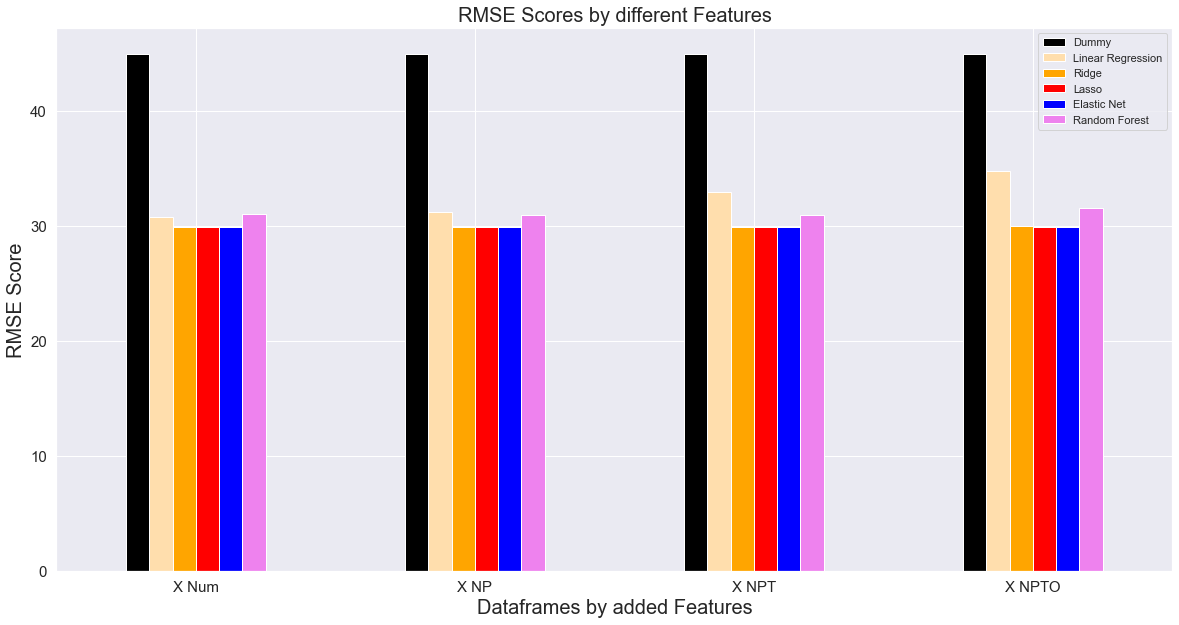

In [330]:
# Colors 
my_color =['black', 'navajowhite', 'orange','red','blue','violet']
 
# Draw a multi-colored bar chart.
_df = pd.DataFrame(res_by_data,columns=["Data Included", "Dummy", "Linear Regression", "Ridge", "Lasso", "Elastic Net", "Random Forest"])
 
_df.plot(x="Data Included", y=["Dummy", "Linear Regression", "Ridge", "Lasso", "Elastic Net", "Random Forest"], 
        kind="bar",figsize=(20,10), color=my_color, fontsize =15, rot = 0)

plt.title(label = "RMSE Scores by different Features", fontsize = 20)
plt.xlabel(xlabel = "Dataframes by added Features", fontsize = 20)
plt.ylabel(ylabel = "RMSE Score", fontsize=20)
 
# Display the plot
plt.show();

In [331]:
sns.set_theme()
sns.set_palette('colorblind')

## Investigating which are the most important coefficients

In [332]:
top5_coef_name = list(test_coef_df.sort_values(by=1,ascending=False)[0][0:4])
top5_coef_val = list(test_coef_df.sort_values(by=1,ascending=False)[1][0:4])

In [333]:
print(top5_coef_name)
print(top5_coef_val)

['Tar', 'Rush_Yds', 'Rec_Yds', 'Pass_Yds']
[0.5677006264294934, 0.10510438392700987, 0.09146123981305478, 0.04140673600804872]


In [334]:
# Cleaning up the feature names, so they'll be clear on the bar graph
top5_coef_name[0] = 'Target'
top5_coef_name[1] = 'Rush Yds'
top5_coef_name[2] = 'Rec Yds'
top5_coef_name[3] = 'Pass Yds'

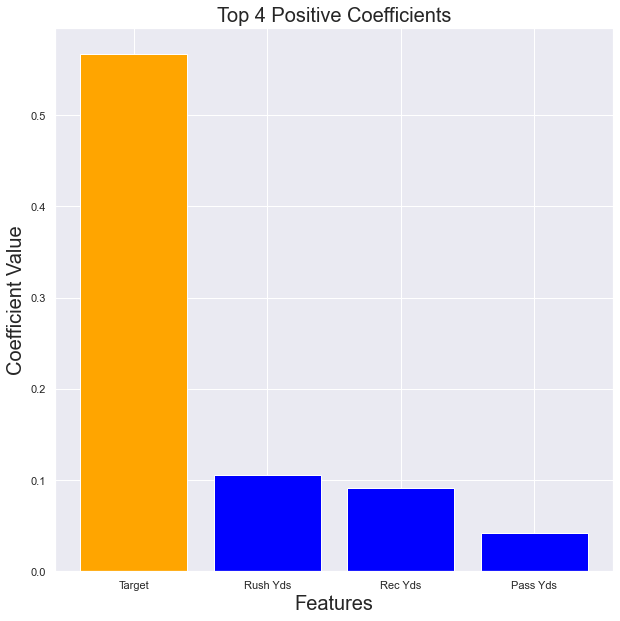

In [335]:
fig, ax = plt.subplots(figsize=(10,10))
colors = ["blue" if i != "Target" else "orange" for i in top5_coef_name]
ax.bar(x = top5_coef_name, height = top5_coef_val, color = colors)

ax.set_title("Top 4 Positive Coefficients", fontsize=20)
ax.set_xlabel("Features",fontsize=20)
ax.set_ylabel("Coefficient Value",fontsize=20)
plt.savefig('images/Top5_Coeff.png');

### Creating a Dataframe of y_test predictions and y
- In order to compare and graph predictions vs actual more easily

In [199]:
error = pd.DataFrame(y_test)

In [200]:
error['pred'] = y_test_pred

In [201]:
error['error'] = error['FP'] - error['pred']

In [202]:
error['%'] = error['error']/error['FP']

### Seeing Actual and Predicted on same graph, stacked on each other

''

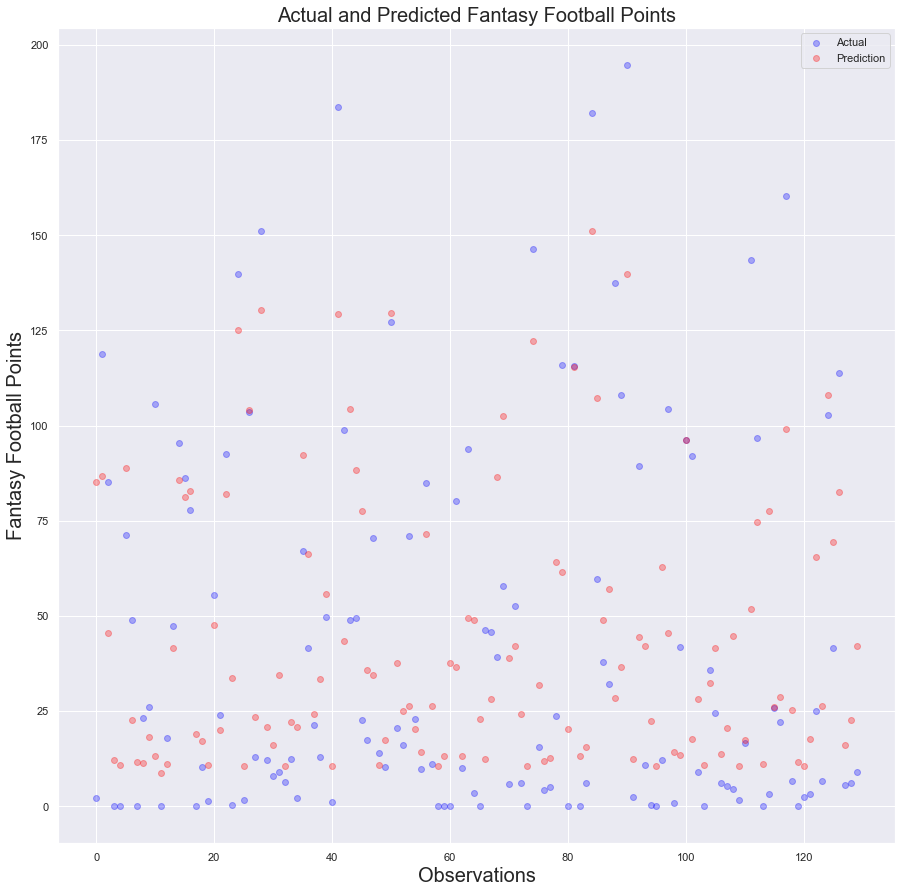

In [203]:
fig, ax = plt.subplots(figsize = (15,15))

ax.scatter(x = range(0, error['FP'].size), y = error['FP'],c='blue',label = 'Actual', alpha=0.3)
ax.scatter(x = range(0, error['pred'].size), y = error['pred'],c='red', label= 'Prediction', alpha=0.3)
plt.title('Actual and Predicted Fantasy Football Points', fontsize= 20)
plt.xlabel('Observations', fontsize= 20)
plt.ylabel('Fantasy Football Points', fontsize= 20)
plt.legend()
plt.savefig('images/actual_and_predicted.png')
;

### Seeing Actual vs Predicted Fantasy Points

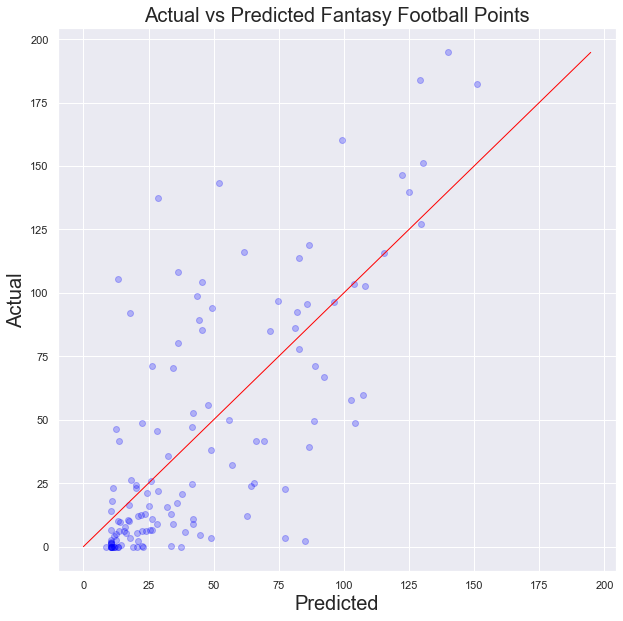

''

In [204]:
fig, ax = plt.subplots(figsize = (10,10))

ax.scatter(x=error['pred'], y = error['FP'],c='blue', alpha=0.25)
plt.title('Actual vs Predicted Fantasy Football Points', fontsize= 20)
plt.xlabel('Predicted', fontsize= 20)
plt.ylabel('Actual', fontsize= 20)

y_max = error['FP'].max()
y_min = error['FP'].min()
X_ref = Y_ref = np.linspace(y_min, y_max)

plt.plot(X_ref, Y_ref, color='red', linewidth=1)
plt.savefig('images/actual_vs_pred.png')
plt.show()
;

### Seeing a histogram of prediction errors
- Want to see where the majority of errors lie, whether they tend to be small or large

''

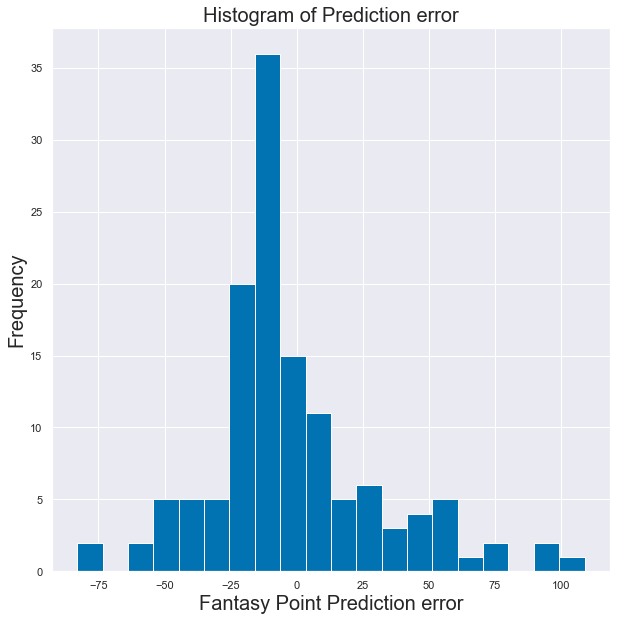

In [205]:
fig, ax = plt.subplots(figsize=(10,10))

ax.hist(error['error'],bins=20)
plt.title('Histogram of Prediction error', fontsize=20)
plt.xlabel('Fantasy Point Prediction error', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.savefig('images/hist_pred_err.png')
;

### Seeing the range in the test data

In [206]:
print(f"Max Points in Test Data: {error['FP'].max()}")
print(f"Min Points in Test Data: {error['FP'].min()}")

Max Points in Test Data: 194.74
Min Points in Test Data: 0.0


# Conclusion

Given the range of fantasy points in the test set, an RMSE of 31.49 is a little high, but on the higher end of the spectrum is not bad at all. In the 150-190 point range if the prediction was off by 30 points then that would only be around a 10%-20% miss. Additionally, as we can see in the histogram above the majority of the errors were very small. Having said that there is much room for improvement and trying to see how features can be added or enhanced via engineering.

To further this test it would be best to try it out in a live setting, but instead of trying to predict an entire half of a season we would like to see how it could do game to game.